In [1]:
import torch
import torch.nn as nn
from pau import PAU

import json
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np
import quad
from utils import init_sequential

torch.set_grad_enabled(False)

FIGURES = Path('figures')
FIGURES_PRED = FIGURES / 'pred'
FIGURES_BASIS = FIGURES / 'basis'
FIGURES_KERNEL = FIGURES / 'kernel'
FIGURES_EIGV = FIGURES / 'eigv'
FIGURES_ERROR = FIGURES / 'error'

FIGURES_PRED.mkdir(exist_ok=True, parents=True)
FIGURES_BASIS.mkdir(exist_ok=True, parents=True)
FIGURES_EIGV.mkdir(exist_ok=True, parents=True)
FIGURES_KERNEL.mkdir(exist_ok=True, parents=True)
FIGURES_ERROR.mkdir(exist_ok=True, parents=True)

ROOT = Path('model')
ARCH = Path('arch')

name = 'S2_qs100_flip'
epoch = 2000

with open(ARCH / f'{name}.json', 'r') as f:
    params = json.load(f)

PATH = ROOT / params['name']

savefig = True
MODEL_PREFIX = r'$S^2_{\theta}$'

FIGURES_PREFIX = f'{params["name"]}_epoch{epoch}'
plt.rc('font', size=14)
plt.rc('lines', linewidth=2)

# FIGURES_PREFIX = f'{params["name"]}_epoch{epoch}_slide'
# plt.rc('font', size=16)
# plt.rc('lines', linewidth=4)

In [2]:
K = init_sequential(
    params['layers'],
    finish_with_activation=params['finish_with_activation'])

In [3]:
data = torch.load(PATH / f'{epoch}.model')
K.load_state_dict(data['K'][0])
print(K)

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): PAU(m=5, n=4, efficient=True)
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): PAU(m=5, n=4, efficient=True)
  (4): Linear(in_features=100, out_features=1, bias=True)
)


In [4]:
match params['quad-name']:
    case 'gaussian':
        int_p, int_w = quad.gaussian_quadrature(0, 1, params['quad-size'])
    case 'trapezoidal':
        int_p, int_w = quad.trapezoidal_rule(0, 1, params['quad-size'])
    case _:
        int_p, int_w = quad.trapezoidal_rule(0, 1, params['quad-size'])

In [5]:
def model_linear(xb, t):
     n = len(t)
     m = xb.shape[1]
     int_p, int_w = quad.gaussian_quadrature(0, 1, m)
    
     result = torch.zeros(xb.shape[0], n)
     for j, t2 in enumerate(t):
         t1t2 = torch.stack((int_p, t2.expand(m))).T
         Kt1t2 = K(t1t2).squeeze()

         for i, xi in enumerate(xb):
             result[i, j] += (xi * Kt1t2) @ int_w
        
     return result


def model_nonlinear(x, p):
    ''' x.shape = (batch_size, p),  p.shape = (num)
    -> (batch_size,)
    For training, p=int_p.

    Computes: x(t) = int K(t,s) Psi(x) x(s) ds
    '''
    # A -> (batch_size, lat_dim),  T -> (num, lat_dim)
    t1, t2 = torch.meshgrid(p, int_p, indexing='xy')
    t1t2 = torch.stack((t1, t2)).reshape(2, -1)
    Kt1t2 = K(t1t2.T).squeeze().reshape((len(p), len(int_p))).flip(1)
    Nonlinear = Psi(x.unsqueeze(-1)).squeeze(-1)
    return torch.einsum('bj,ij,j->bi', Nonlinear, Kt1t2, int_w)

In [6]:
if params.get('Psi'):
    Psi = init_sequential(
            params['Psi-layers'],
            finish_with_activation=params['Psi-finish_with_activation'])
    Psi_opt = torch.optim.Adam(Psi.parameters(), lr=1e-4)

    data = torch.load(PATH / f'{epoch}.model')
    Psi.load_state_dict(data['Psi'][0])
    print(Psi)
    
    model = model_nonlinear
else:
    model = model_linear

In [7]:
x_ds, y_ds = torch.load(ROOT / f'{params["name"]}/valid.ds')
ds_file = f'dataset/{params["ds"]}/valid/'
ds_size = len(x_ds)
ds_step = ds_size // 5

/home/dasvaca/Documents/ms/operator_learning/venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/dasvaca/Documents/ms/operator_learning/venv/lib/python3.12/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


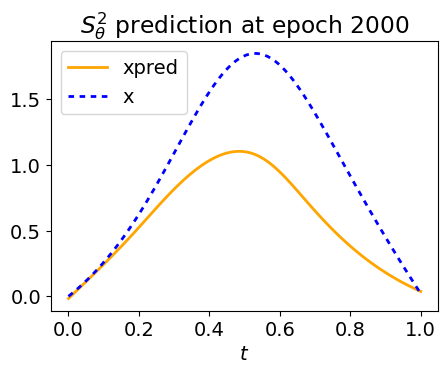

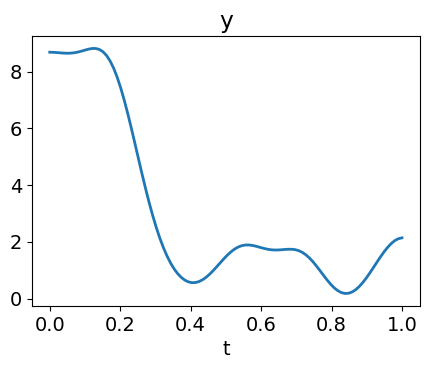

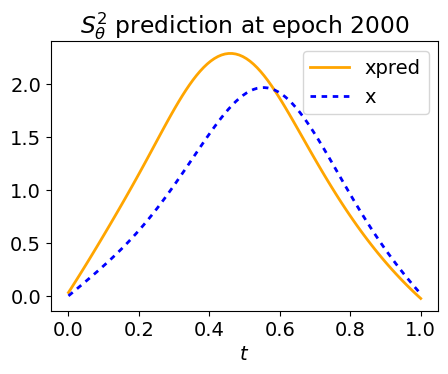

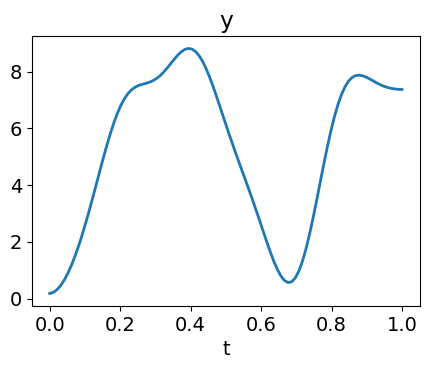

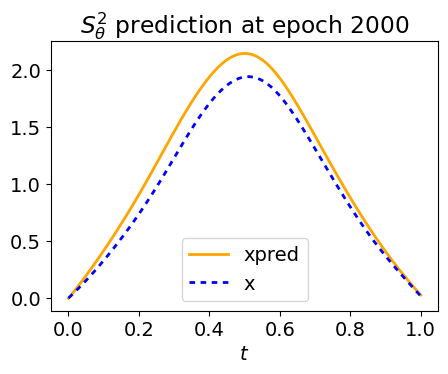

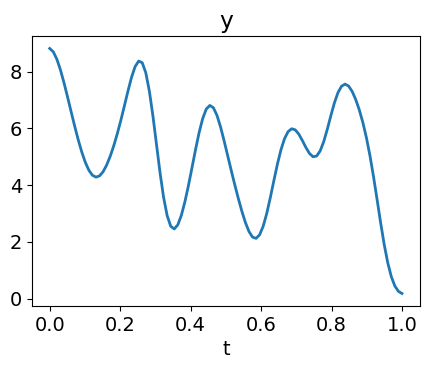

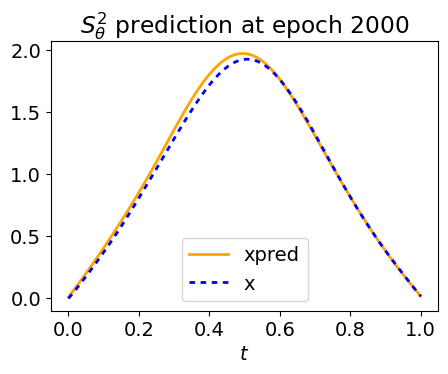

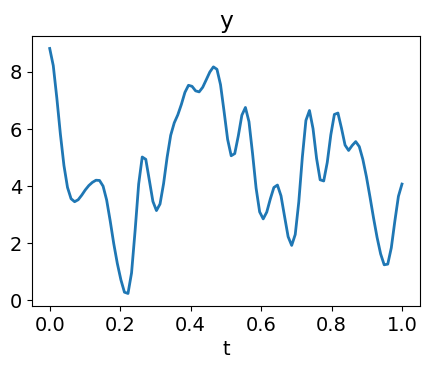

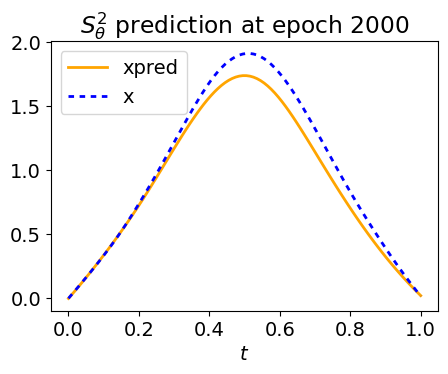

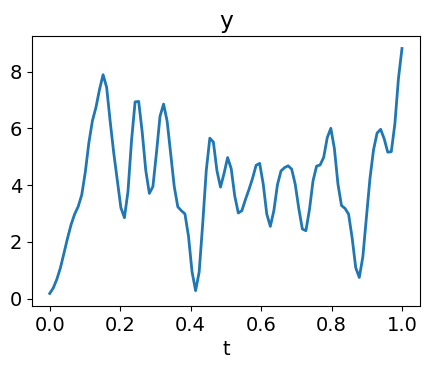

In [8]:
for i, j in enumerate(range(0, ds_size, ds_step)):
    xpred = model(x_ds[j].unsqueeze(0), int_p).squeeze()

    plt.figure(figsize=(5, 3.5))
    plt.tight_layout()

    plt.plot(int_p, xpred, c='orange', label='xpred')
    plt.plot(int_p, y_ds[j], 'b--', dashes=[2], label='x')
    plt.xlabel(r'$t$')
    plt.legend()
    if savefig:
        plt.savefig(FIGURES_PRED / f'{FIGURES_PREFIX}_Fig{i}.png', bbox_inches='tight')
    
    plt.title(MODEL_PREFIX + f' prediction at epoch {epoch}')
    if savefig:
        plt.savefig(FIGURES_PRED / f'{FIGURES_PREFIX}_Fig{i}_with_title.png', bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(5, 3.5))
    plt.plot(int_p, x_ds[j])
    plt.xlabel('t')
    if savefig:
        plt.savefig(FIGURES_PRED / f'{FIGURES_PREFIX}_y_Fig{i}.png', bbox_inches='tight')
    plt.title('y')
    if savefig:
        plt.savefig(FIGURES_PRED / f'{FIGURES_PREFIX}_y_Fig{i}_with_title.png', bbox_inches='tight')
    plt.show()

In [9]:
N = 200
t = torch.linspace(0, 1, N)
tt = torch.stack(torch.meshgrid((t,t),
    indexing='xy')).reshape(2, -1)

In [10]:
k = K(tt.T)

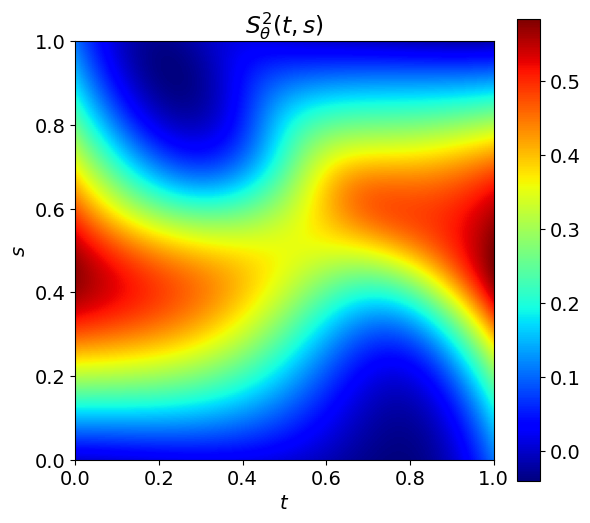

In [11]:
plt.figure(figsize=(6, 6))
plt.imshow(k.reshape(N, N).flip(1), cmap='jet', extent=[0,1,0,1])
plt.title(MODEL_PREFIX + r'$(t,s)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$s$')
plt.colorbar(fraction=0.05)
if savefig:
    plt.savefig(FIGURES_KERNEL / f'{FIGURES_PREFIX}.png', bbox_inches='tight')
plt.show()

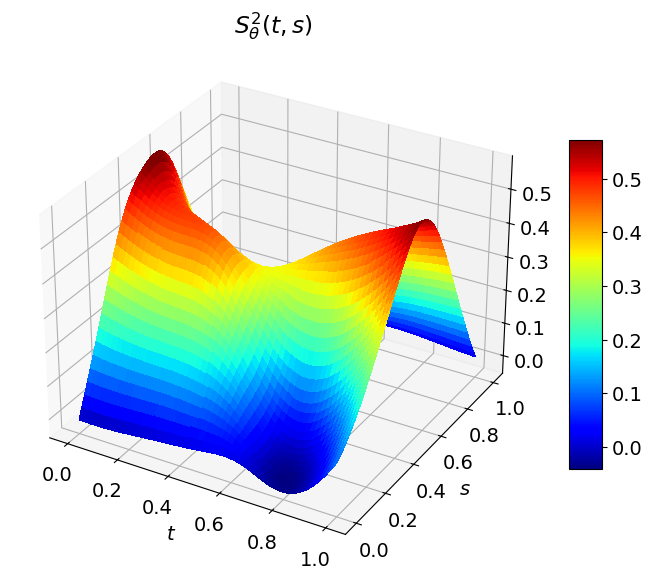

In [12]:
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": "3d"})
fig.tight_layout()

surf = ax.plot_surface(tt[0].reshape(N, N), tt[1].reshape(N,N), k.reshape(N, N), cmap='jet',
                       linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=10)
ax.set_title(MODEL_PREFIX + r'$(t,s)$')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$s$')

if savefig:
    plt.savefig(FIGURES_KERNEL / f'{FIGURES_PREFIX}_3d.png', bbox_inches='tight')

plt.show()

In [13]:
if params.get('Psi'):
    s = torch.linspace(0, 9, 500)
    plt.figure(figsize=(5, 4))
    plt.tight_layout()
    plt.plot(s, Psi(s.unsqueeze(1)).squeeze())
    plt.ylabel(r'$\Psi_{\theta}(t)$')
    plt.xlabel('t')
    plt.title(r'$\Psi_{\theta}(t)$')
    if savefig:
        plt.savefig(FIGURES_KERNEL / f'{FIGURES_PREFIX}_Psi.png', bbox_inches='tight')
    plt.show()

 Error

In [14]:
def read_error_log(logfile, rf, maxepoch=float('infinity')):
    error = []
    with open(logfile, 'r') as f:
        for line in f:
            ep, err = line.strip().split(',')
            ep = int(ep)
            err = float(err)

            if ep > maxepoch:
                break
            
            if ep % rf == 0:
                error.append(err)
    return error

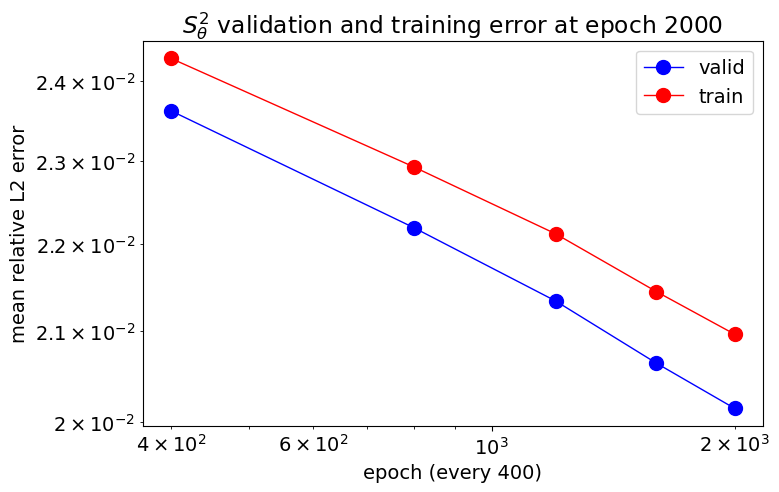

<Figure size 800x500 with 0 Axes>

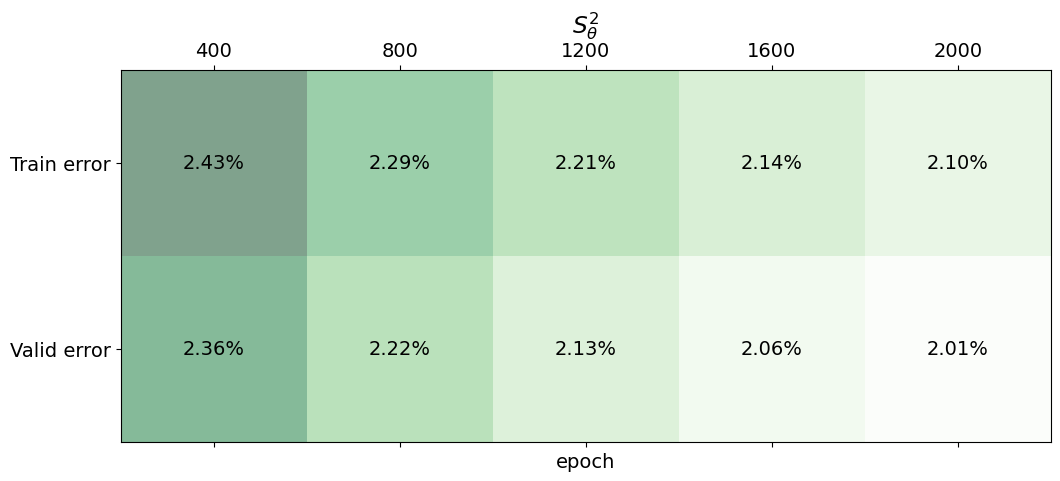

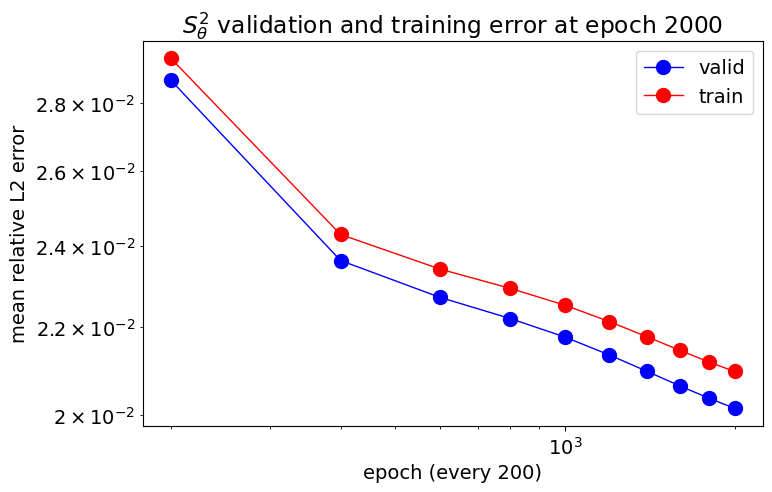

<Figure size 800x500 with 0 Axes>

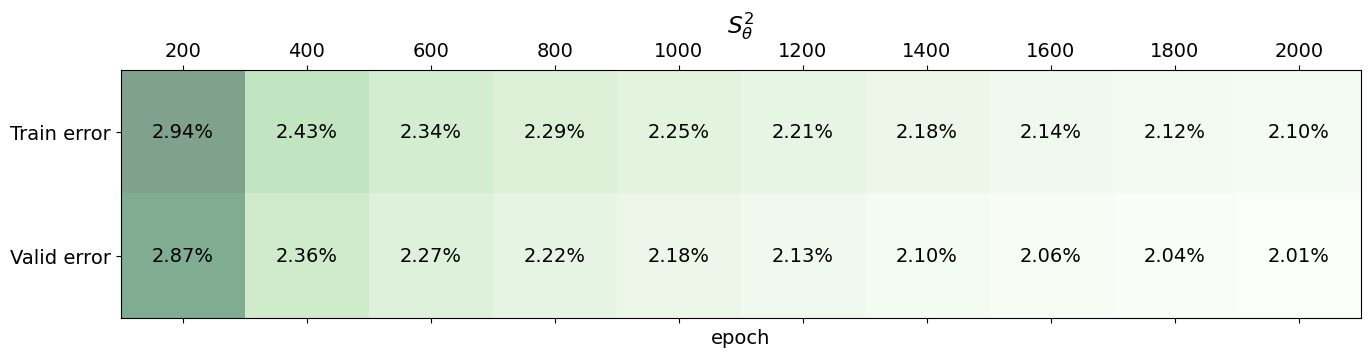

In [15]:
for rf_ in [5, 10]:
    rf = epoch // rf_
    timeline = [i for i in range(rf, epoch+rf, rf)]
    
    valid_error = read_error_log(PATH / 'valid.error', rf, maxepoch=epoch)
    train_error = read_error_log(PATH / 'train.error', rf, maxepoch=epoch)

    ##  PLOT
    plt.figure(figsize=(8, 5))
    plt.loglog(timeline, valid_error, '-ob', label='valid', markersize=10, linewidth=1)
    plt.loglog(timeline, train_error, '-or', label='train', markersize=10, linewidth=1)
    plt.title(MODEL_PREFIX + f' validation and training error at epoch {epoch}')
    plt.xlabel(f'epoch (every {rf})')
    plt.ylabel('mean relative L2 error')
    plt.legend()
    if savefig:
        plt.savefig(FIGURES_ERROR / f'{FIGURES_PREFIX}_rf{rf_}.png', bbox_inches='tight')
    plt.show()

    ##  TABLE
    data = np.array(list(zip(train_error, valid_error))).T

    plt.figure(figsize=(8, 5))
    plt.tight_layout()
    plt.matshow(100 * data, cmap='Greens', alpha=0.5)
    plt.xlabel('epoch')
    plt.xticks(np.array(range(len(timeline))), timeline)
    plt.yticks(list(range(2)), ['Train error', 'Valid error'])
    
    for (i, j), z in np.ndenumerate(data):
        plt.text(j, i, '{:0.2f}%'.format(100 * z), ha='center', va='center')

    if savefig:
        plt.savefig(FIGURES_ERROR / f'{FIGURES_PREFIX}_table_rf{rf_}.png', bbox_inches='tight')
    
    plt.title(MODEL_PREFIX)
    if savefig:
        plt.savefig(FIGURES_ERROR / f'{FIGURES_PREFIX}_table_rf{rf_}_with_title.png', bbox_inches='tight')
    
    plt.show()

 Eigenfunction

In [16]:
U, S, V = torch.svd(k.reshape(N, N))

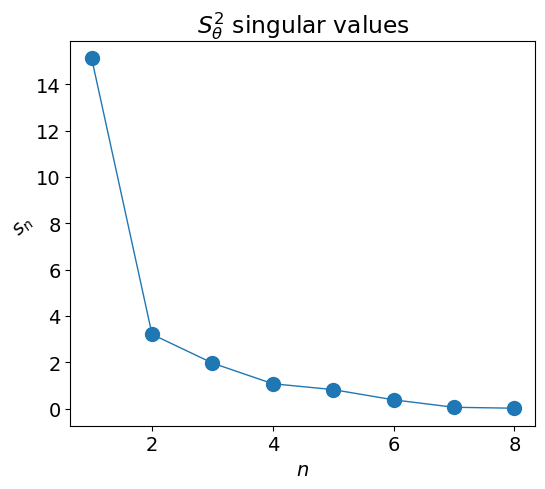

In [17]:
SVAL = torch.tensor(sorted(1/S[:8], reverse=True))

plt.figure(figsize=(6, 5))
plt.xlabel(r'$n$')
plt.ylabel(r'$s_n$', rotation=45)
plt.title(MODEL_PREFIX + f' singular values')
plt.plot(list(range(1, len(SVAL)+1)), SVAL, '-o', markersize=10, linewidth=1)

if savefig:
    plt.savefig(FIGURES_EIGV / f'{FIGURES_PREFIX}.png', bbox_inches='tight')
plt.show()

In [18]:
import numpy as np

domain = np.arange(len(SVAL))

np.polyfit(domain, np.log(SVAL), 1)

array([-0.85638929,  2.58212454])

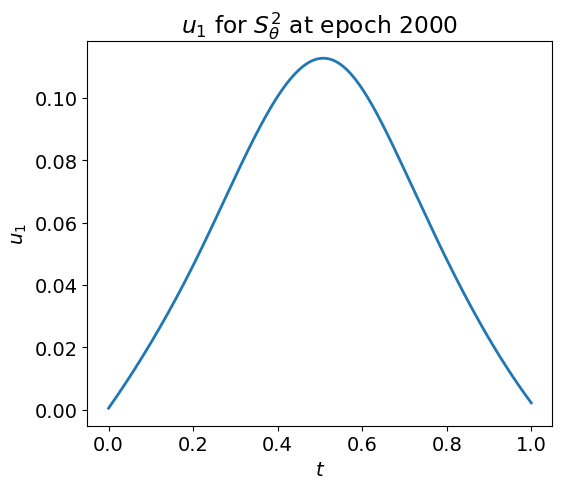

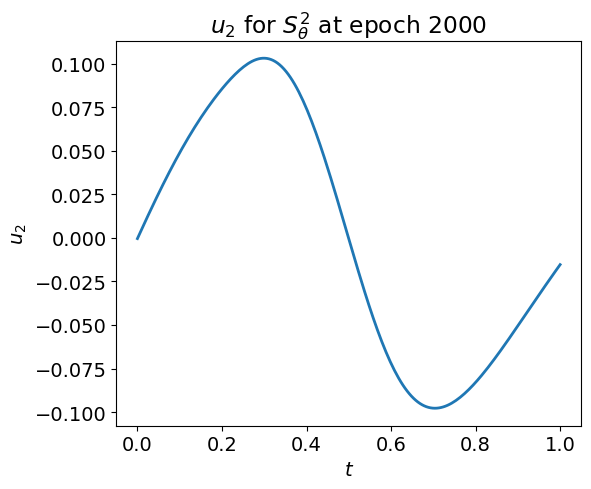

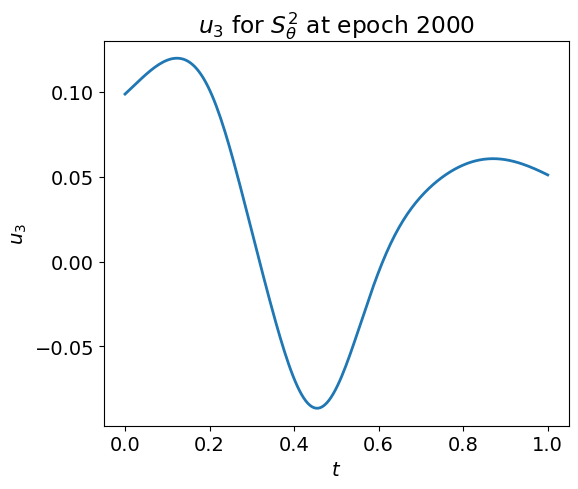

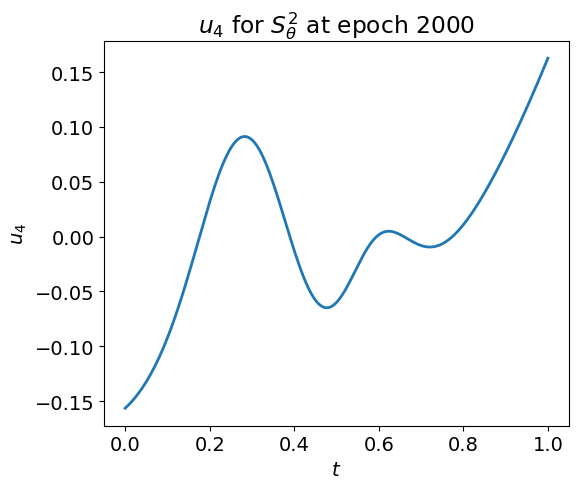

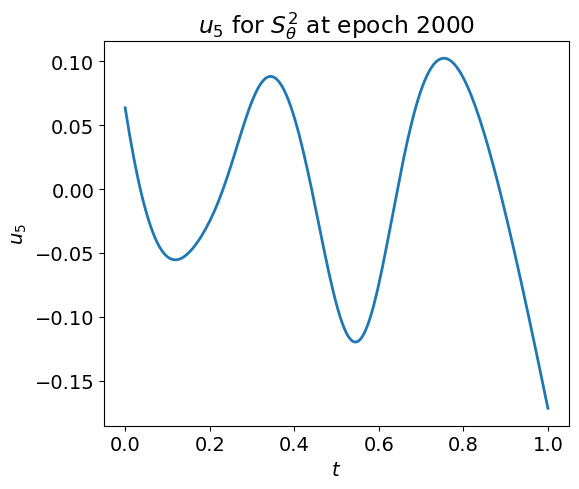

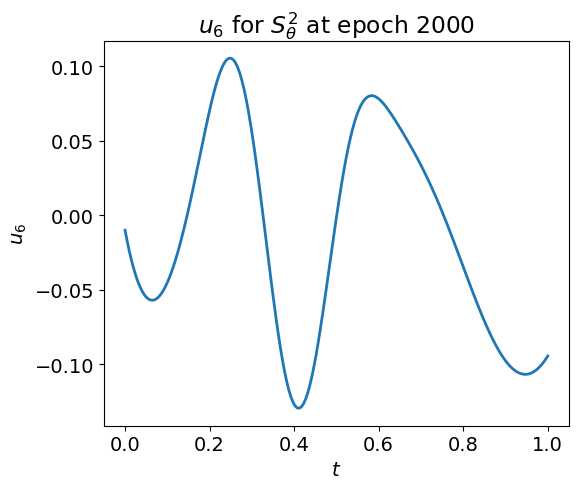

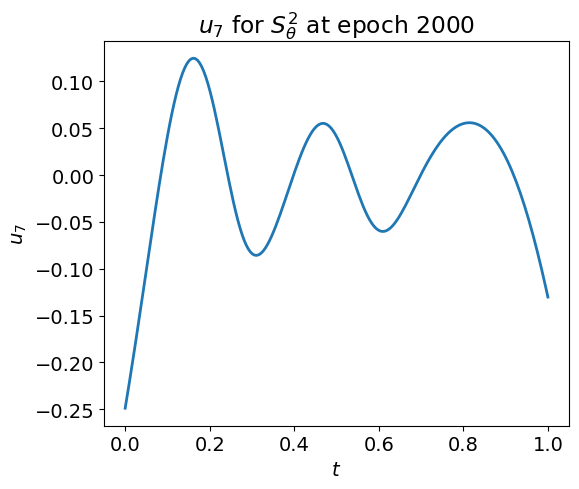

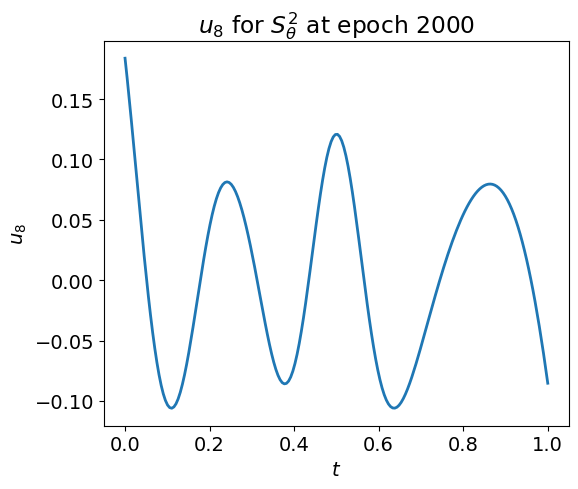

In [19]:
BASIS_U = U[:, :8].T
for i, b in enumerate(BASIS_U):
    plt.figure(figsize=(6, 5))
    plt.xlabel(r'$t$')
    plt.ylabel(r'$u_{}$'.format(i+1))
    plt.plot(t, b)
    
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_u{i}.png', bbox_inches='tight')
    
    plt.title('$u_{}$'.format(i+1) + f' for {MODEL_PREFIX} at epoch {epoch}')
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_u{i}_with_title.png', bbox_inches='tight')
    plt.show()

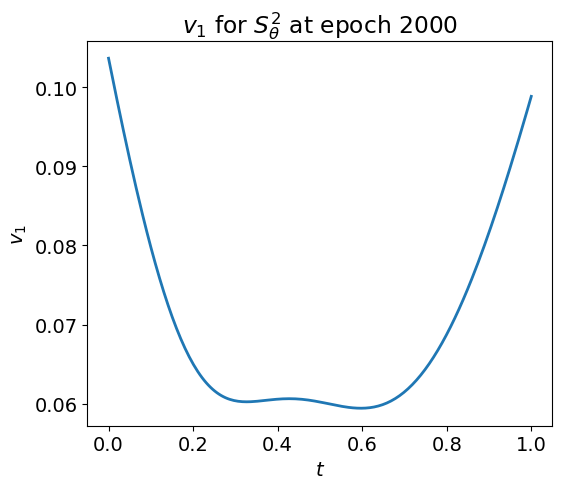

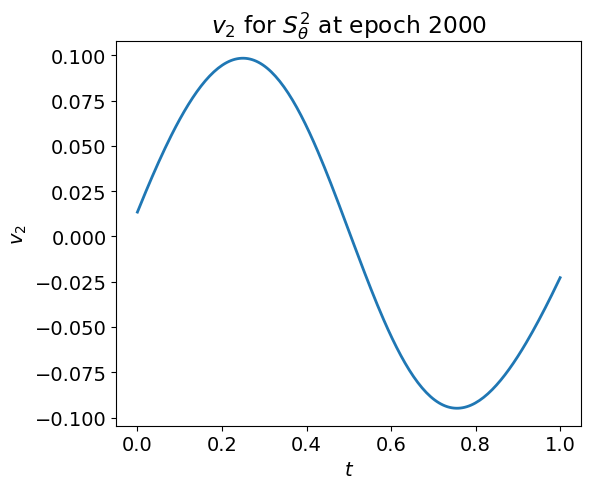

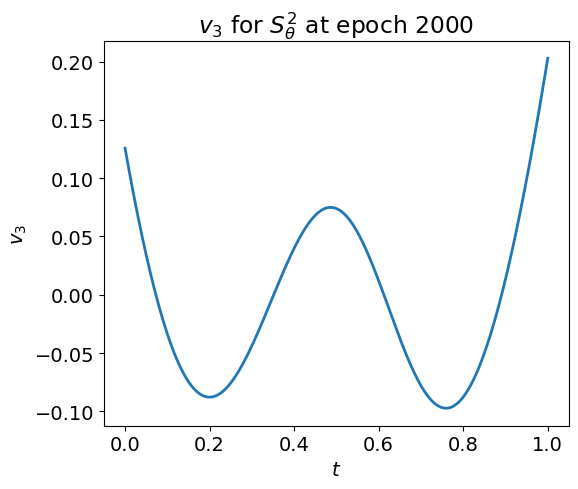

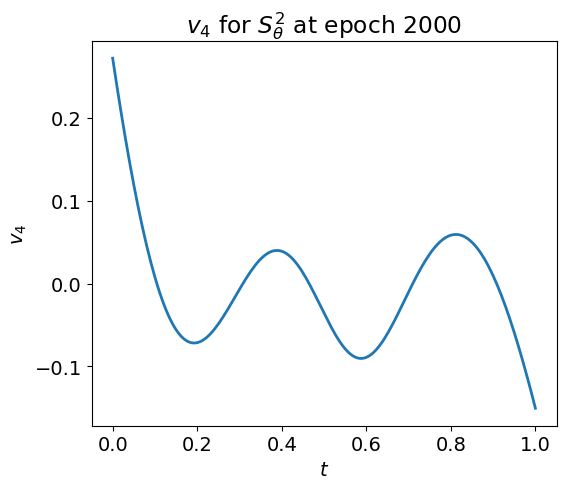

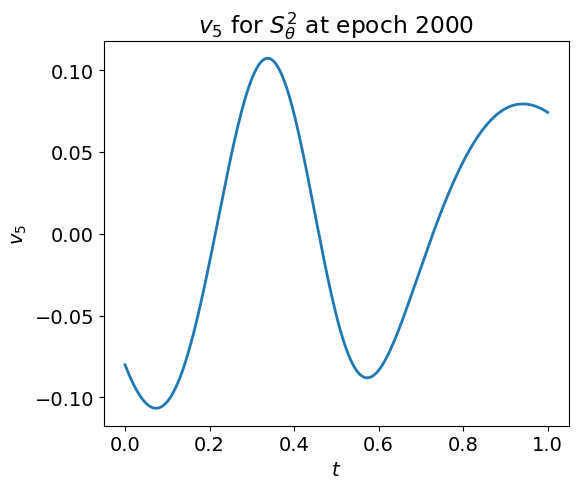

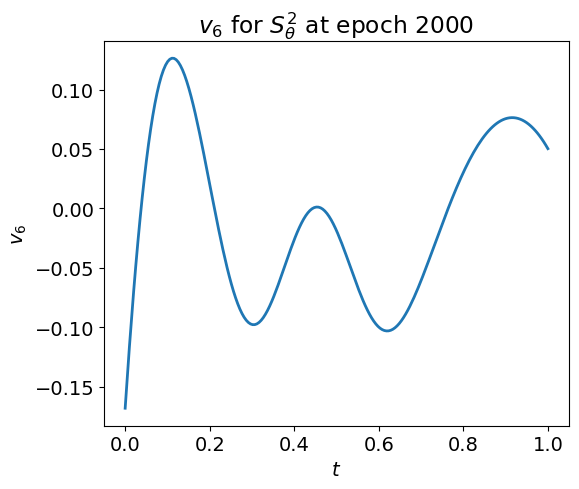

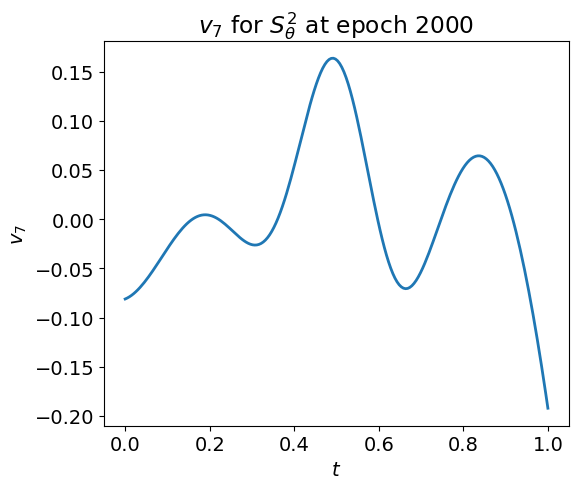

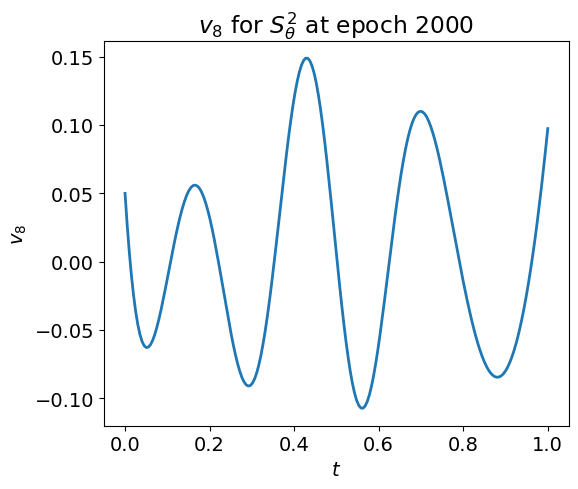

In [20]:
BASIS_V = V[:, :8].T
for i, b in enumerate(BASIS_V):
    plt.figure(figsize=(6, 5))
    plt.xlabel(r'$t$')
    plt.ylabel(r'$v_{}$'.format(i+1))
    plt.plot(t, b)
    
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_v{i}.png', bbox_inches='tight')

    plt.title('$v_{}$'.format(i+1) + f' for {MODEL_PREFIX} at epoch {epoch}')
    if savefig:
        plt.savefig(FIGURES_BASIS / f'{FIGURES_PREFIX}_v{i}_with_title.png', bbox_inches='tight')
    plt.show()